  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:08<00:00, 1146.94it/s]


Text(0, 0.5, 'MAE')

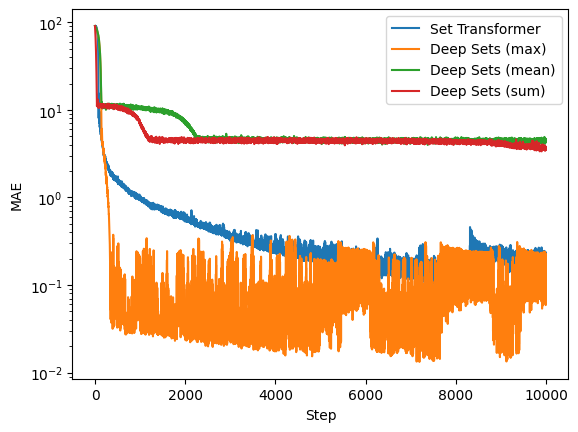

In [6]:
import jax.numpy as jnp 
import jax.random as jr
import equinox as eqx
import jax 
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import set_transformerx
from set_transformerx.modules import SAB, PMA
#jax.disable_jit(disable=True)

def gen_data(batch_size, max_length=10, test=False):
    """
    Generate set problem: find maximum value in a set
    """
    length = 10#np.random.randint(1, max_length + 1)
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    x, y = np.expand_dims(x, axis=2), np.expand_dims(y, axis=1)
    return x, y


"""
def gen_data(batch_size, length, key):
    ks = jr.split(key, 2)
    x = jr.randint(ks[1], (batch_size, length[0]), 1, 100)
    y = jnp.max(x, axis=1)
    x,y = jnp.expand_dims(x, axis=-1), jnp.expand_dims(y, axis=-1)
    return x, y 
"""

class DeepSet(eqx.Module):
    enc: eqx.nn.Sequential
    dec: eqx.nn.Sequential
    pool: callable
    def __init__(self, pool="max", *, key):
        ks = jr.split(key, 6)
        self.enc = eqx.nn.MLP(in_size=1, out_size=64, width_size=64, depth=2, activation=jax.nn.relu, key=ks[0])
        self.dec = eqx.nn.MLP(in_size=64, out_size=1, width_size=64, depth=1, activation=jax.nn.relu, key=ks[1])
        """
        self.enc = eqx.nn.Sequential([
            jax.vmap(eqx.nn.Linear(1, 64, key=ks[0])),
            eqx.nn.Lambda(jax.nn.relu),
            jax.vmap(eqx.nn.Linear(64, 64, key=ks[1])),
            eqx.nn.Lambda(jax.nn.relu),
            jax.vmap(eqx.nn.Linear(64, 64, key=ks[2])),
            eqx.nn.Lambda(jax.nn.relu),
            jax.vmap(eqx.nn.Linear(64, 64, key=ks[3])),
        ])
        
        self.dec = eqx.nn.Sequential([
            eqx.nn.Linear(64, 64, key=ks[4]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(64, 1, key=ks[5]),
        ])
        """
        
        if pool == "max":
            self.pool = lambda x: jnp.max(x, axis=0)
        elif pool == "mean":
            self.pool = lambda x: jnp.mean(x, axis=0)
        elif pool == "sum":
            self.pool = lambda x: jnp.sum(x, axis=0)
        else:
            raise ValueError(f"Unknown pooling method: {pool}")
        
    @eqx.filter_jit
    def __call__(self, x):
        x = jax.vmap(self.enc)(x)
        x = self.pool(x)
        x = self.dec(x)
        return x

class SetTransformer(eqx.Module):
    blocks: eqx.nn.Sequential
    pooling: eqx.nn.Sequential
    out: eqx.nn.Sequential
    def __init__(self, ln=False):
        self.blocks = [
            SAB(dim_in=1, dim_out=64, num_heads=4, ln=ln),
            SAB(dim_in=64, dim_out=64, num_heads=4, ln=ln),
            SAB(dim_in=64, dim_out=64, num_heads=4, ln=ln)
        ]
        self.pooling = PMA(dim=64, num_heads=4, num_seeds=1, ln=ln, mlp_kwargs={"width_size": 16, "depth":3})
        self.out = eqx.nn.Linear(64, 1, key=jr.PRNGKey(0))
    def __call__(self, x):
        for b in self.blocks:
            x = b(x)
        x = self.pooling(x)
        x = jax.vmap(self.out)(x)
        return jnp.squeeze(x, axis=-1)

@eqx.filter_jit
def loss_fn(model, x, y): 
    y_pred = jax.vmap(model)(x)
    return jnp.mean(jnp.abs(y_pred - y))

#_gen_data = lambda length, key: gen_data(batch_size=2**10, length=length, key=key)
#gen_datas = [jax.jit(lambda key: _gen_data(i, key) ) for i in range(2,10)]

def train(model, key, n_step=10000):
    optim = optax.adam(1e-4)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))


    @eqx.filter_jit
    def make_step(model, opt_state, x, y):
        loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss
    
    losses = []
    for _ in tqdm(range(n_step)):
        key, subkey = jr.split(key)
        x, y = gen_data(batch_size=2 ** 10, max_length=10)
        model, opt_state, loss = make_step(model, opt_state, x, y)
        losses.append(loss)
    return model, jnp.array(losses)

models = [
    ("Set Transformer", SetTransformer()),
    ("Deep Sets (max)", DeepSet("max", key=jr.PRNGKey(0))),
    ("Deep Sets (mean)", DeepSet("mean", key=jr.PRNGKey(0))),
    ("Deep Sets (sum)", DeepSet("sum", key=jr.PRNGKey(0))),
]

for name, model in models:
    key = jr.PRNGKey(0)
    ks = jr.split(key, 2)
    model, losses = train(model, key)
    plt.plot(losses, label=name)

plt.yscale("log")
plt.legend()
plt.xlabel("Step")
plt.ylabel("MAE")
